In [1]:
from datetime import datetime 
from siphon.simplewebservice.wyoming import WyomingUpperAir
from metpy.units import units, pandas_dataframe_to_unit_arrays
import matplotlib.pyplot as plt
import metpy.plots as plots
#from metpy.plots import add_onamet_logo
import metpy.calc as mpcalc
import numpy as np
from matplotlib.pyplot import imread

%matplotlib inline

In [2]:
date = datetime(2021, 7, 9, 12) #sept-10-2017 @ 0000z
station = '78486'

df = WyomingUpperAir.request_data(date, station)
d  = pandas_dataframe_to_unit_arrays(df)

# p = d['pressure']
# t = d['temperature']
# td = d['dewpoint']
# u = d['u_wind']
# v = d['v_wind']
# h = d['height']

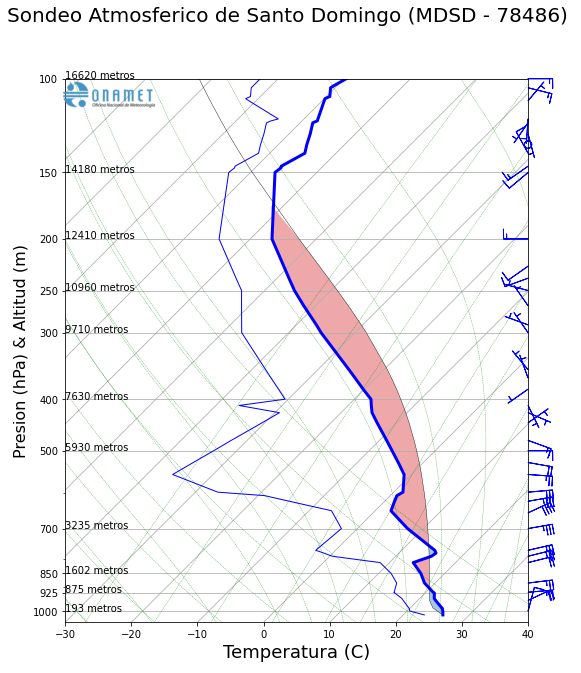

In [3]:
fig = plt.figure(figsize=(10, 10))
skew = plots.SkewT(fig, rotation = 45)

skew.plot(d['pressure'], d['temperature'], 'b', linewidth = 3)
skew.plot(d['pressure'], d['dewpoint'], 'b', linewidth = 1)

skew.ax.set_ylim(1050, 100)
skew.ax.set_xlim(-30, 40)

fig.suptitle('Sondeo Atmosferico de Santo Domingo (MDSD - 78486)', fontsize = 20)
plt.xlabel('Temperatura (C)', fontsize = 18)
plt.ylabel('Presion (hPa) & Altitud (m)', fontsize = 16)
plt.yticks(ticks=[1000, 925, 850, 700, 500, 400, 300, 250, 200, 150, 100])

interval = np.logspace(2, 3) * units.hPa
idx = mpcalc.resample_nn_1d(d['pressure'], interval)
skew.plot_barbs(d['pressure'][idx], d['u_wind'][idx], d['v_wind'][idx], barbcolor = 'blue', sizes = 
               dict(width = 0.01))

skew.plot_dry_adiabats(colors = 'green', linewidth = 0.4, alpha = 0.7)
skew.plot_moist_adiabats(colors = 'green', linewidth = 0.4, alpha = 0.7)

p_space = np.linspace(100, max(skew.ax.get_ylim())) * units.mbar
skew.plot_mixing_lines(pressure = p_space, colors = 'green', linewidth = 0.4, alpha = 0.7)
#skew.plot_mixing_lines(colors = 'green', linewidth = 0.4, alpha = 0.7)

parcel_path = mpcalc.parcel_profile(d['pressure'], d['temperature'][0], d['dewpoint'][0])
skew.plot(d['pressure'], parcel_path, color = 'k', linewidth = 0.4)

mask = d['pressure'] >= 200 * units.hPa
skew.shade_cape(d['pressure'], d['temperature'], parcel_path)
skew.shade_cin(d['pressure'][mask], d['temperature'][mask], parcel_path[mask])


logo = imread('onamet_75x75.png')
fig.figimage(logo, 60, 565, zorder=100)

#interval = [k for k in range(1000, 0, -100)] * units.hPa
interval = [1000, 925, 850, 700, 500, 400, 300, 250, 200, 150, 100] * units.hPa
idx = mpcalc.resample_nn_1d(d['pressure'], interval)
for p, t, h  in zip(d['pressure'][idx], d['temperature'][idx], d['height'][idx]):
    if p >= 100 * units.hPa:
        skew.ax.text(-0.0001, p, f'{round(h.m, 0)} metros', fontsize=10, 
                     transform = skew.ax.get_yaxis_transform(which='tick2'))

In [4]:
# skew.ax.set_facecolor('lightblue')
# fig.patch.set_color('bisque')
# fig

In [5]:
# skew.ax.axvline(x=0, ymin=0, ymax=0.28, color='c', linestyle='--', linewidth=2)
# lcl_pressure, lcl_temperature = mpcalc.lcl(d['pressure'][0], d['temperature'][0], d['dewpoint'][0])
# skew.plot(lcl_pressure, lcl_temperature, color = 'black', marker = 'o', markerfacecolor='red')
# fig

In [6]:
lcl_pressure, lcl_temperature = mpcalc.lcl(d['pressure'][0], d['temperature'][0], d['dewpoint'][0])
lfc_pressure, lfc_temperature = mpcalc.lfc(d['pressure'], d['temperature'], d['dewpoint'])
el_pressure, el_temperature = mpcalc.el(d['pressure'], d['temperature'], d['dewpoint'])

# skew.ax.axhline(lcl_pressure)

sfc_cape, sfc_cin = mpcalc.surface_based_cape_cin(d['pressure'], d['temperature'], d['dewpoint'])
mtsu_cape, mstu_cin = mpcalc.most_unstable_cape_cin(d['pressure'], d['temperature'], d['dewpoint'])

li = mpcalc.lifted_index(d['pressure'], d['temperature'], parcel_path)

pw = mpcalc.precipitable_water(d['pressure'], d['dewpoint'])



In [7]:
idx = np.where(d['pressure'] == 850 * units.hPa)
idx = idx[0][0]
T850 = d['temperature'][idx]
TD850 = d['dewpoint'][idx]
WS850 = d['speed'][idx]
WD850 = d['speed'][idx]
pressure_set_from_850  = d['pressure'][idx:]
parcel_path_850 = mpcalc.parcel_profile(pressure_set_from_850, d['temperature'][idx], d['dewpoint'][idx])

idx = np.where(d['pressure'] == 500 * units.hPa)
idx = idx[0][0]
T500 = d['temperature'][idx]
Tp500 = parcel_path[idx].to(units.degC)
WS500 = d['speed'][idx]
WD500 = d['speed'][idx]


idx = np.where(d['pressure'] == 700 * units.hPa)
idx = idx[0][0]
T700 = d['temperature'][idx]
TD700 = d['dewpoint'][idx]

idx = np.where(pressure_set_from_850 == 500 * units.hPa)
idx = idx[0][0]
Tp500_850 = parcel_path_850[idx].to(units.degC)


KINX = ( T850 - T500 ) + TD850 - ( T700 - TD700 ) 
CTOT = TD850 - T500 
VTOT = T850 - T500 
TOTL = ( T850 - T500 ) + ( TD850 - T500 )
SHOW = T500 - Tp500_850


#######SWET = 12 * TD850 + 20 * TERM2 + 2 * SKT850 + SKT500 + SHEAR 
if TOTL.m > 49 or 130 <= WD850.m <= 250 or 210 <= WD500.m <= 310 or WD500.m - WD850.m > 0:
    a = 1
elif WS500.m >= 15 and WS850.m >= 15:
    a = 1
else:
    a = 0
SWET = 12*TD850.m + 20 * a * TOTL.m + 2*WS850.m + WS500.m + 125 * a *(float(np.sin(WD500.m - WD850.m)) + 0.2)


#######SHOW WALTER INDEX
# idx = np.where(d['pressure'] == 850 * units.hPa)
# idx = idx[0][0]
# idx
# p_850  = d['pressure'][idx:]
# t_850  = d['temperature'][idx]
# td_850 = d['dewpoint'][idx]

# parcel_path_850 = mpcalc.parcel_profile(p_850, t_850, td_850)
# #skew.plot(p_850, parcel_path_850, color = 'k', linewidth = 0.8)


# idx = np.where(p_850 == 500 * units.hPa)
# idx = idx[0][0]


# Tp500_850 = parcel_path_850[idx].to(units.degC)
# SHOW = T500 - Tp500_850

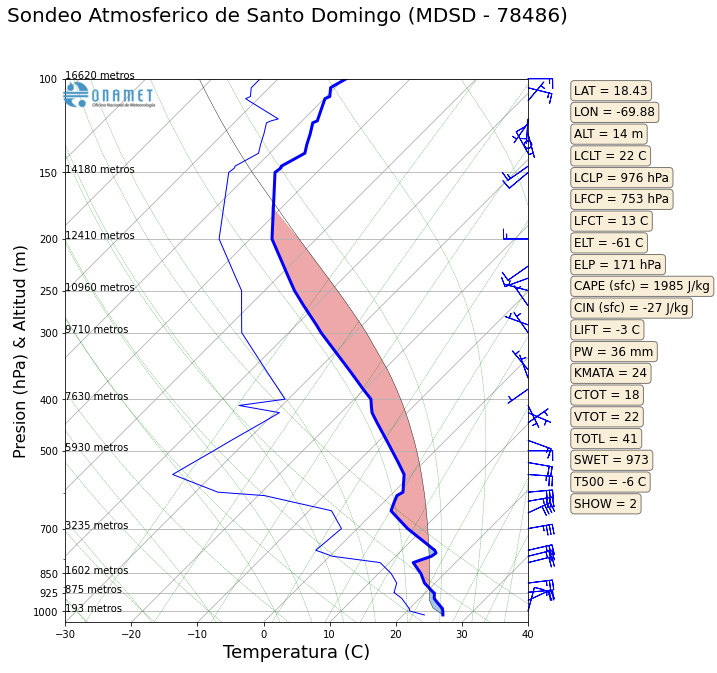

In [8]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# indexes = [lcl_pressure, lcl_temperature, lfc_pressure, lfc_temperature, el_pressure, el_temperature, 
#            sfc_cape, sfc_cin, mtsu_cape, mstu_cin, li, pw]

txts     = [f'LAT = 18.43', f'LON = -69.88', f'ALT = 14 m',            
            f'LCLT = {int(lcl_temperature.m)} C', f'LCLP = {int(lcl_pressure.m)} hPa', 
            f'LFCP = {int(lfc_pressure.m)} hPa', f'LFCT = {int(lfc_temperature.m)} C', 
            f'ELT = {int(el_temperature.m)} C', f'ELP = {int(el_pressure.m)} hPa',
            f'CAPE (sfc) = {int(sfc_cape.m)} J/kg', f'CIN (sfc) = {int(sfc_cin.m)} J/kg',
            f'LIFT = {int(li.m)} C', f'PW = {int(pw.m)} mm', f'KMATA = {int(KINX.m)}',
            f'CTOT = {int(CTOT.m)}', f'VTOT = {int(VTOT.m)}', f'TOTL = {int(TOTL.m)}',
            f'SWET = {int(SWET)}', f'T500 = {int(T500.m)} C', f'SHOW = {int(SHOW.m)}']

xtxt = 1.1
ytxt = 0.99

for txt in txts:
    skew.ax.text(xtxt, ytxt, txt, transform=skew.ax.transAxes, fontsize=12,
                 verticalalignment='top', bbox=props)
    ytxt = ytxt - 0.04
fig

In [9]:
parcel_path = mpcalc.parcel_profile(d['pressure'], d['temperature'][0], d['dewpoint'][0])
skew.plot(d['pressure'], parcel_path, color = 'k', linewidth = 0.4)

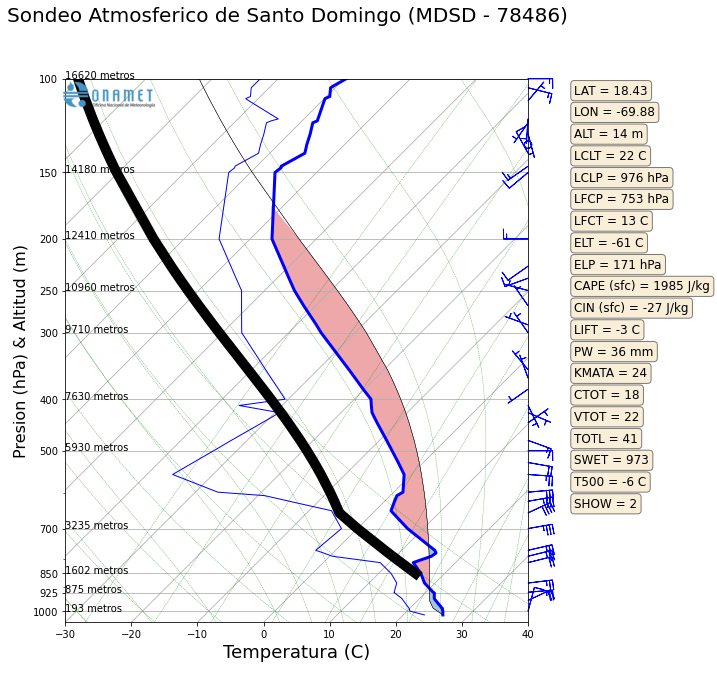

In [10]:
parcel_path_850 = mpcalc.parcel_profile(pressure_set_from_850, d['temperature'][idx], d['dewpoint'][idx])
skew.plot(pressure_set_from_850, parcel_path_850, color = 'k', linewidth = 10)
fig

In [19]:
idx = np.where(pressure_set_from_850 == 850 * units.hPa)
idx = idx[0][0]
parcel_path_850.to(units.degC)[idx]

-19.371220493945856 <Unit('degree_Celsius')>

In [18]:
pressure_set_from_850
           

Magnitude,[850.0 811.0 801.0 789.0 778.0 769.0 700.0 654.0 648.0 622.0 607.0 598.0 554.0 526.0 500.0 478.0 443.0 424.0 411.0 400.0 383.0 365.0 352.0 300.0 290.0 267.0 250.0 237.0 225.0 200.0 150.0 147.0 146.0 140.0 138.0 133.0 127.0 121.0 120.0 119.0 110.0 109.0 108.0 104.0 103.0 100.0]
Units,hectopascal
